# Bundesliga Season End Prediction
**Important: Run cells sequentially from top to bottom (Shift+Enter or Run All). Each cell depends on variables created by previous cells.**

This notebook predicts the final league standings for the Bundesliga season based on Monte Carlo simulations.

## 1. Setup and Configuration

In [1]:
# Import required libraries
import sys
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add parent directory to path so we can import src module
sys.path.insert(0, "..")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 10)

### Load Configuration

Import the configuration file for your league. Configuration files are stored in the `configs/` directory.

In [2]:
# Load configuration for the league
config_file = "../configs/bundesliga.yaml"  # Change this to use a different league

with open(config_file, "r") as f:
    config = yaml.safe_load(f)

print(f"League: {config['league']['name']}")
print(f"Country: {config['league']['country']}")
print(f"Season: {config['league']['current_season']}")

League: Bundesliga
Country: Germany
Season: 2025


## 2. Data Loading and Preparation

Load and prepare match data from the configured sources.

In [3]:
# Import data loading and preprocessing modules
from src.data import (
    load_fixture_csv,
    load_match_statistics,
    normalize_team_names,
    prepare_match_statistics,
)
from src.preprocessing import (
    calculate_home_team_statistics,
    calculate_away_team_statistics,
    calculate_efficiency_metrics,
    calculate_league_table,
)
from src.preprocessing.utils import (
    create_played_matches_dataframe,
    create_remaining_matches_dataframe,
)

# Load fixtures data
fixtures_path = f"../data/raw/{config['data_sources']['all_matches']['filename']}"
fixtures = load_fixture_csv(fixtures_path)

# Normalize team names based on configuration
fixtures = normalize_team_names(fixtures, config.get("team_name_mapping", {}))

print(f"Loaded {len(fixtures)} fixtures")
print(f"Fixtures shape: {fixtures.shape}")
print(f"\nFirst 5 fixtures:")
print(fixtures.head())

Loaded 306 fixtures
Fixtures shape: (306, 7)

First 5 fixtures:
   Match Number  Round Number              Date                Location  \
0             1             1  22/08/2025 18:30           Allianz Arena   
1             2             1  23/08/2025 13:30             Voith-Arena   
2             4             1  23/08/2025 13:30  An der Alten Försterei   
3             7             1  23/08/2025 13:30     Europa-Park Stadion   
4             8             1  23/08/2025 13:30      Deutsche Bank Park   

               Home Team         Away Team Result  
0      FC Bayern München        RB Leipzig  6 - 0  
1  1. FC Heidenheim 1846     VfL Wolfsburg  1 - 3  
2     1. FC Union Berlin     VfB Stuttgart  2 - 1  
3    Sport-Club Freiburg       FC Augsburg  1 - 3  
4    Eintracht Frankfurt  SV Werder Bremen  4 - 1  


In [4]:
# Load match statistics
statistics = load_match_statistics(
    f"../data/raw/{config['data_sources']['match_statistics']['filename']}"
)

# Prepare statistics: standardize columns and normalize team names
statistics = prepare_match_statistics(statistics, config)

print(f"Loaded {len(statistics)} match results")
print(f"Statistics shape: {statistics.shape}")
print(f"\nFirst 5 matches:")
print(statistics.head())

Loaded 179 match results
Statistics shape: (179, 10)

First 5 matches:
         Date              Home Team         Away Team  Home Goals  \
0  22/08/2025      FC Bayern München        RB Leipzig           6   
1  23/08/2025    Eintracht Frankfurt  SV Werder Bremen           4   
2  23/08/2025    Sport-Club Freiburg       FC Augsburg           1   
3  23/08/2025  1. FC Heidenheim 1846     VfL Wolfsburg           1   
4  23/08/2025    Bayer 04 Leverkusen    TSG Hoffenheim           1   

   Away Goals Result  Home Shots  Away Shots  Home Shots on Target  \
0           0      H          19          12                    10   
1           1      H          18          10                     5   
2           3      A          16          14                     4   
3           3      A           7          15                     2   
4           2      A           7          10                     2   

   Away Shots on Target  
0                     1  
1                     5  
2        

In [5]:
# Separate played and remaining matches
played_matches = create_played_matches_dataframe(statistics)
remaining_matches = create_remaining_matches_dataframe(fixtures)

print(f"Played matches: {len(played_matches)}")
print(f"Remaining matches: {len(remaining_matches)}")
print(f"\nRemaining matches sample:")
print(remaining_matches.head())

Played matches: 179
Remaining matches: 127

Remaining matches sample:
               Home Team            Away Team
0           Hamburger SV  Bayer 04 Leverkusen
1     1. FC Union Berlin  Eintracht Frankfurt
2  1. FC Heidenheim 1846         Hamburger SV
3           FC St. Pauli        VfB Stuttgart
4          VfL Wolfsburg    Borussia Dortmund


## 3. Team Statistics Analysis

Calculate statistics for each team in their home and away performances.

In [6]:
# Calculate home and away team statistics
home_stats = calculate_home_team_statistics(statistics)
away_stats = calculate_away_team_statistics(statistics)

# Calculate efficiency metrics
home_stats, away_stats = calculate_efficiency_metrics(home_stats, away_stats)

print("Home Team Statistics (sorted by attacking efficiency):")
print(
    home_stats.sort_values("home_attack_eff", ascending=False)[
        ["avg_home_goals_scored", "home_attack_eff", "home_defense_eff"]
    ].head(10)
)

Home Team Statistics (sorted by attacking efficiency):
                     avg_home_goals_scored  home_attack_eff  home_defense_eff
Home Team                                                                    
FC Bayern München                      4.0         0.204082          0.097826
TSG Hoffenheim                         2.4         0.167832          0.104000
Borussia Dortmund                      2.2         0.152778          0.080000
Eintracht Frankfurt                    1.7         0.136000          0.173077
Sport-Club Freiburg                    2.0         0.135338          0.122222
RB Leipzig                             2.3         0.132948          0.110169
1. FC Köln                             1.8         0.126761          0.126050
Bayer 04 Leverkusen                    2.0         0.123457          0.103093
VfL Wolfsburg                          1.6         0.119403          0.148936
1. FC Union Berlin                     1.5         0.119048          0.131148


In [7]:
print("\nAway Team Statistics (sorted by attacking efficiency):")
print(
    away_stats.sort_values("away_attack_eff", ascending=False)[
        ["avg_away_goals_scored", "away_attack_eff", "away_defense_eff"]
    ].head(10)
)


Away Team Statistics (sorted by attacking efficiency):
                          avg_away_goals_scored  away_attack_eff  \
Away Team                                                          
Eintracht Frankfurt                    2.300000         0.200000   
FC Bayern München                      3.400000         0.186813   
Bayer 04 Leverkusen                    2.000000         0.174757   
Borussia Dortmund                      1.900000         0.169643   
TSG Hoffenheim                         1.900000         0.166667   
VfB Stuttgart                          2.300000         0.150327   
1. FSV Mainz 05                        1.300000         0.139785   
VfL Wolfsburg                          1.200000         0.117647   
Borussia Mönchengladbach               1.200000         0.112150   
Sport-Club Freiburg                    1.181818         0.106557   

                          away_defense_eff  
Away Team                                   
Eintracht Frankfurt               0.1

## 4. Current League Table

Show the current league standings before simulation.

In [8]:
# Calculate current league table
current_league_table = calculate_league_table(played_matches)

print(
    f"Current League Table (after {current_league_table['Played'].head(1).values[0]} matches played):\n"
)
print(
    current_league_table[
        [
            "Position",
            "Team",
            "Played",
            "Wins",
            "Draws",
            "Losses",
            "Goals For",
            "Goals Against",
            "Goal Difference",
            "Points",
        ]
    ].to_string(index=False)
)

Current League Table (after 20 matches played):

 Position                     Team  Played  Wins  Draws  Losses  Goals For  Goals Against  Goal Difference  Points
        1        FC Bayern München      20    16      3       1         74             18               56      51
        2        Borussia Dortmund      20    13      6       1         41             19               22      45
        3           TSG Hoffenheim      20    13      3       4         43             23               20      42
        4            VfB Stuttgart      20    12      3       5         37             26               11      39
        5               RB Leipzig      20    11      3       6         38             27               11      36
        6      Bayer 04 Leverkusen      19    11      2       6         38             26               12      35
        7      Sport-Club Freiburg      20     7      6       7         31             33               -2      27
        8      Eintracht Frankf

## 5. Monte Carlo Simulation

Run Monte Carlo simulations to predict final league table positions.

In [9]:
# Import Monte Carlo simulation functions
from src.modelling import (
    monte_carlo_simulation,
    calculate_position_probabilities,
    get_team_final_position_stats,
)

# Run Monte Carlo simulation
n_simulations = config["simulation"]["n_simulations"]
random_seed = config["simulation"]["random_seed"]

print(f"Running {n_simulations} Monte Carlo simulations...")

league_tables_sim, full_season_results_sim = monte_carlo_simulation(
    fixtures,
    played_matches,
    home_stats,
    away_stats,
    n_simulations=n_simulations,
    random_seed=random_seed,
)

print(f"Completed {len(league_tables_sim)} simulations")

Running 1000 Monte Carlo simulations...
Completed 1000 simulations


In [10]:
# Calculate position probabilities
position_probs = calculate_position_probabilities(
    league_tables_sim, current_league_table
)

print("\nFinal Position Probabilities:")
print(position_probs)


Final Position Probabilities:
                             1      2      3      4      5      6      7   \
FC Bayern München         0.993  0.006  0.001  0.000  0.000  0.000  0.000   
Borussia Dortmund         0.004  0.441  0.302  0.134  0.078  0.034  0.007   
TSG Hoffenheim            0.002  0.359  0.307  0.179  0.102  0.046  0.005   
VfB Stuttgart             0.001  0.085  0.141  0.239  0.259  0.197  0.069   
RB Leipzig                0.000  0.037  0.098  0.193  0.242  0.290  0.118   
Bayer 04 Leverkusen       0.000  0.072  0.146  0.237  0.254  0.204  0.071   
Sport-Club Freiburg       0.000  0.000  0.000  0.003  0.008  0.052  0.188   
Eintracht Frankfurt       0.000  0.000  0.005  0.015  0.057  0.172  0.457   
1. FC Union Berlin        0.000  0.000  0.000  0.000  0.000  0.001  0.023   
1. FC Köln                0.000  0.000  0.000  0.000  0.000  0.003  0.046   
FC Augsburg               0.000  0.000  0.000  0.000  0.000  0.000  0.007   
Borussia Mönchengladbach  0.000  0.000  0.000

## 6. Visualization of Results

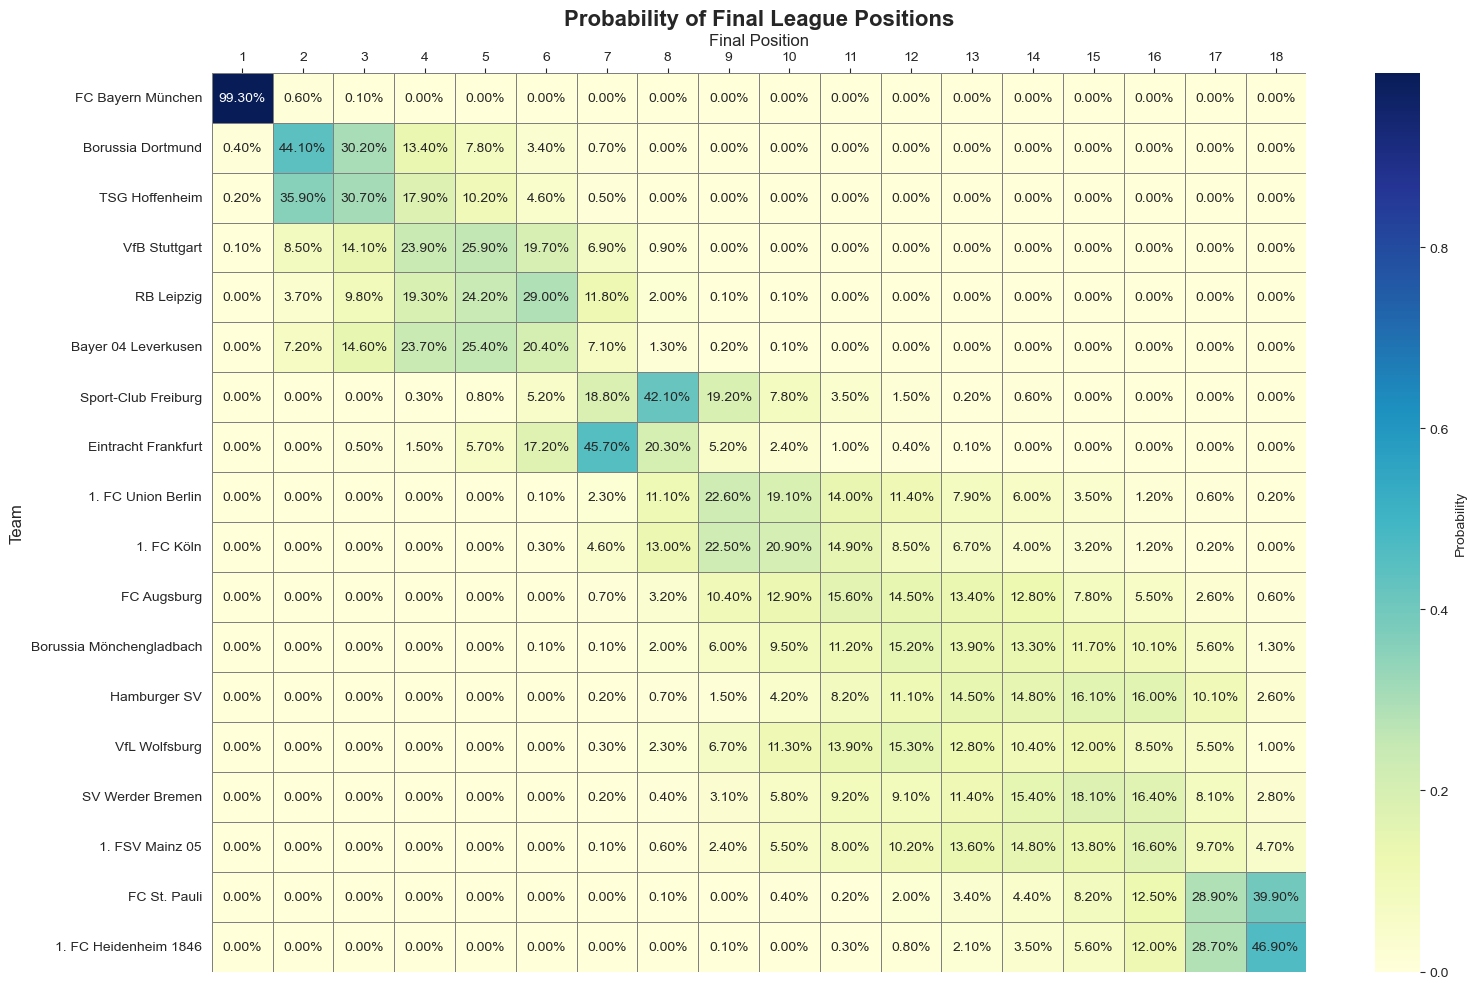

In [11]:
# Import visualization functions
from src.visualization import (
    plot_position_probabilities_heatmap,
    plot_team_position_distribution,
    plot_multiple_teams_distribution,
)

# Create heatmap visualization
plot_position_probabilities_heatmap(position_probs)

## 7. Detailed Team Analysis

Generate detailed statistics for each team's expected final position.

In [12]:
# Generate team statistics report
team_names = current_league_table["Team"].tolist()
team_stats_report = {}

for team in team_names:
    team_stats_report[team] = get_team_final_position_stats(position_probs, team)

# Create a DataFrame for better visualization
stats_df = pd.DataFrame(team_stats_report).T
stats_df = stats_df.sort_values("most_likely_position")

print("Team Final Position Statistics:\n")
print(stats_df)

Team Final Position Statistics:

                          most_likely_position  most_likely_prob  \
FC Bayern München                          1.0             0.993   
Borussia Dortmund                          2.0             0.441   
TSG Hoffenheim                             2.0             0.359   
VfB Stuttgart                              5.0             0.259   
Bayer 04 Leverkusen                        5.0             0.254   
RB Leipzig                                 6.0             0.290   
Eintracht Frankfurt                        7.0             0.457   
Sport-Club Freiburg                        8.0             0.421   
1. FC Köln                                 9.0             0.225   
1. FC Union Berlin                         9.0             0.226   
FC Augsburg                               11.0             0.156   
Borussia Mönchengladbach                  12.0             0.152   
VfL Wolfsburg                             12.0             0.153   
Hamburger SV   

## 8. Top Teams Analysis

Compare position distributions for top teams.

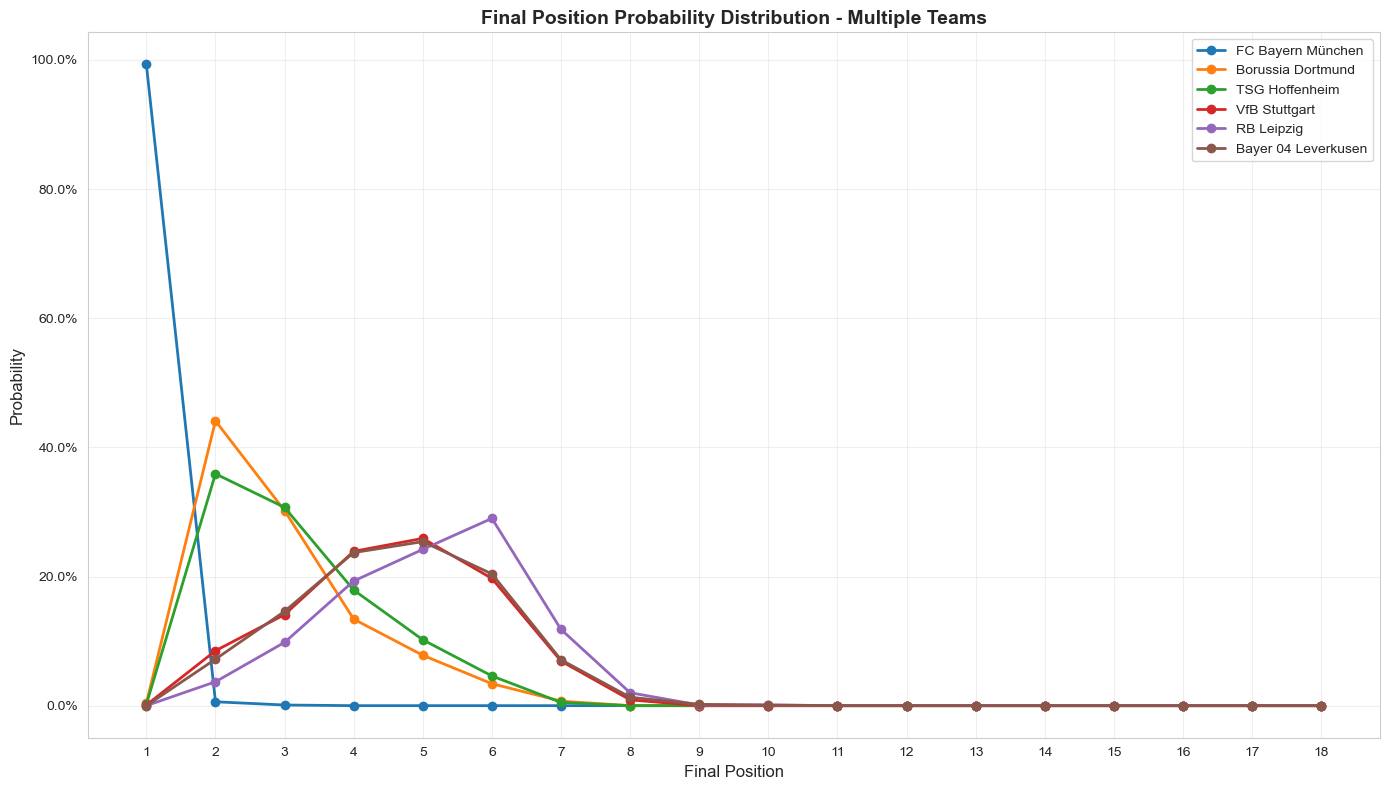

In [13]:
# Analyze top 6 teams
top_6_teams = current_league_table.head(6)["Team"].tolist()

plot_multiple_teams_distribution(position_probs, top_6_teams)

## 9. Summary and Conclusions

Key findings from the Monte Carlo simulation.

In [14]:
# Summary statistics
print(f"League: {config['league']['name']}")
print(f"Season: {config['league']['current_season']}")
print(f"Monte Carlo Simulations: {n_simulations}")
print()

print("Championship Probabilities (Top 3):")
for i, team in enumerate(stats_df.head(3).index, 1):
    prob = position_probs.loc[team, 1]
    print(f"{i}. {team}: {prob:.2%}")

print("\nRelegation Zone Probabilities (Bottom 3):")
n_positions = len(position_probs.columns)
for team in stats_df.tail(3).index:
    prob_bottom_3 = position_probs.loc[team, n_positions - 2 : n_positions].sum()
    print(f"{team}: {prob_bottom_3:.2%}")

League: Bundesliga
Season: 2025
Monte Carlo Simulations: 1000

Championship Probabilities (Top 3):
1. FC Bayern München: 99.30%
2. Borussia Dortmund: 0.40%
3. TSG Hoffenheim: 0.20%

Relegation Zone Probabilities (Bottom 3):
1. FSV Mainz 05: 31.00%
FC St. Pauli: 81.30%
1. FC Heidenheim 1846: 87.60%
